In [ ]:
!pip install -q qiskit
!pip install -q qiskit_aer
!pip install -q pylatexenc
!pip install -q qiskit-ibm-runtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 92.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.4/377.4 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 12.8 MB/s eta 0:00:00


In [ ]:
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit.quantum_info import Statevector
import numpy as np
import math
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer.noise import depolarizing_error, NoiseModel

In [ ]:
def initalize_circuit_key(key):
  length = len(key)
  qc = QuantumCircuit(length, length)
  for i in range(length):
    if key[i] == 1:
      qc.h(i)
  qc.barrier()
  return qc
def encoder(qc, basis):
  length = len(basis)
  for i in range(length):
    if basis[i] == 'X':
      qc.x(i)
    if basis[i] =='Z':
      qc.z(i)
  return qc

Running p = 0.0000  (1/40) ...First transpiled circuit (text):

      ░ ┌───┐ ░ ┌───┐┌─┐
  q: ─░─┤ I ├─░─┤ H ├┤M├
      ░ └───┘ ░ └───┘└╥┘
c: 1/═════════════════╩═
                      0 

---- end of transpiled circuit ----

 QBER=0.0000, sifted=518
Running p = 0.0103  (2/40) ... QBER=0.0094, sifted=533
Running p = 0.0205  (3/40) ... QBER=0.0145, sifted=551
Running p = 0.0308  (4/40) ... QBER=0.0150, sifted=534
Running p = 0.0410  (5/40) ... QBER=0.0244, sifted=532
Running p = 0.0513  (6/40) ... QBER=0.0462, sifted=520
Running p = 0.0615  (7/40) ... QBER=0.0645, sifted=543
Running p = 0.0718  (8/40) ... QBER=0.0636, sifted=535
Running p = 0.0821  (9/40) ... QBER=0.0668, sifted=539
Running p = 0.0923  (10/40) ... QBER=0.1012, sifted=573
Running p = 0.1026  (11/40) ... QBER=0.0906, sifted=563
Running p = 0.1128  (12/40) ... QBER=0.0881, sifted=556
Running p = 0.1231  (13/40) ... QBER=0.1046, sifted=583
Running p = 0.1333  (14/40) ... QBER=0.0926, sifted=583
Running p = 0.1436  (15/40) 

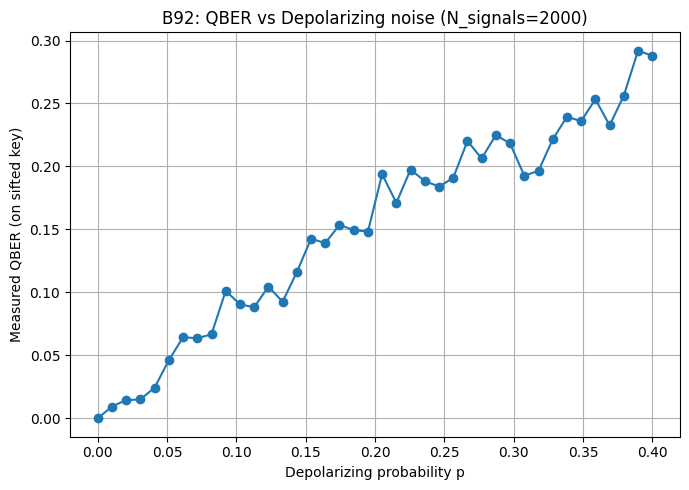

In [ ]:


# ---------- Utilities ----------

def prepare_b92_qasm_with_id_barrier(alice_bit: int, bob_basis: int):
    """
    Build one single-shot B92 circuit with barriers around an 'id' gate so the transpiler
    is less likely to remove it.
    """
    qc = QuantumCircuit(1, 1)
    if alice_bit == 1:
        qc.h(0)           # prepare |+> for bit 1
    qc.barrier(0)
    qc.id(0)            # placeholder for noise model
    qc.barrier(0)
    if bob_basis == 0:
        qc.measure(0, 0)
    else:
        qc.h(0)
        qc.measure(0, 0)
    return qc

def build_depolarizing_noise_model(p_noise: float):
    err = depolarizing_error(p_noise, 1)
    nm = NoiseModel()
    nm.add_all_qubit_quantum_error(err, ['id'])
    return nm

def run_b92_qasm_noise_batch(N_signals, p_noise, seed=42, shots_per_circ=1, debug_first=False):
    """
    Build N single-shot circuits and run them in one batch on Aer qasm simulator with NoiseModel.
    Use transpile(..., optimization_level=0) to avoid removal of id/barrier.
    Returns measured QBER on sifted key and sifted length.
    """
    rng = np.random.RandomState(seed)
    alice = rng.randint(0, 2, size=N_signals)
    bob_bases = rng.randint(0, 2, size=N_signals)

    circuits = []
    for i in range(N_signals):
        qc = prepare_b92_qasm_with_id_barrier(int(alice[i]), int(bob_bases[i]))
        qc.name = f"b92_{i}"
        circuits.append(qc)

    backend = Aer.get_backend('aer_simulator')
    transpiled = transpile(circuits, backend=backend, optimization_level=0)

    if debug_first and len(transpiled) > 0:
        print("First transpiled circuit (text):\n")
        print(transpiled[0].draw(output='text'))
        print("\n---- end of transpiled circuit ----\n")

    noise_model = build_depolarizing_noise_model(p_noise)

    job = backend.run(transpiled, noise_model=noise_model, shots=shots_per_circ, memory=True)
    result = job.result()

    siftA = []
    siftB = []
    errors = 0
    conclusive = inconclusive = 0

    for i in range(N_signals):
        mem = result.get_memory(i)
        bitstr = mem[0]
        measured = int(bitstr[-1])
        a = int(alice[i])
        b = int(bob_bases[i])

        if b == 0:
            # Z-check: measured==1 -> infer bit=1
            if measured == 1:
                conclusive += 1
                siftA.append(a); siftB.append(1)
                if a != 1: errors += 1
            else:
                inconclusive += 1
        else:
            # X-check (H then measure): measured==1 -> |-> -> infer bit=0
            if measured == 1:
                conclusive += 1
                siftA.append(a); siftB.append(0)
                if a != 0: errors += 1
            else:
                inconclusive += 1

    siftA = np.array(siftA, dtype=int)
    siftB = np.array(siftB, dtype=int)
    qber = float(np.mean(siftA != siftB)) if len(siftA) > 0 else float('nan')

    return {'QBER': qber, 'sifted_len': len(siftA), 'conclusive': conclusive, 'inconclusive': inconclusive}


def sweep_qber_vs_noise(p_list, N_signals=2000, seed=42, shots_per_circ=1, debug_first=False):
    qbers = []
    sifted_lengths = []
    for idx, p in enumerate(p_list):
        print(f"Running p = {p:.4f}  ({idx+1}/{len(p_list)}) ...", end='', flush=True)
        stats = run_b92_qasm_noise_batch(N_signals, p, seed=seed, shots_per_circ=shots_per_circ, debug_first=(debug_first and idx==0))
        qbers.append(stats['QBER'])
        sifted_lengths.append(stats['sifted_len'])
        print(f" QBER={stats['QBER']:.4f}, sifted={stats['sifted_len']}")
    return np.array(qbers), np.array(sifted_lengths)

N_signals = 2000            # number of signals per p value; reduce if slow
p_list = np.linspace(0.0, 0.4, 40)  # sweep from 0 to 0.2 (21 points)
seed = 123
shots = 1

qbers, sifted = sweep_qber_vs_noise(p_list, N_signals=N_signals, seed=seed, shots_per_circ=shots, debug_first=True)

plt.figure(figsize=(7,5))
plt.plot(p_list, qbers, marker='o', linestyle='-')
plt.xlabel('Depolarizing probability p')
plt.ylabel('Measured QBER (on sifted key)')
plt.title(f'B92: QBER vs Depolarizing noise (N_signals={N_signals})')
plt.grid(True)
plt.tight_layout()
plt.show()

eve_frac=0.00  | sifted=1897  | QBER=0.3200  | Eve_known=   0  | Eve_acc=nan
eve_frac=0.10  | sifted=1934  | QBER=0.3371  | Eve_known= 225  | Eve_acc=0.8
eve_frac=0.20  | sifted=1915  | QBER=0.3457  | Eve_known= 445  | Eve_acc=0.7707865168539326
eve_frac=0.30  | sifted=1975  | QBER=0.3448  | Eve_known= 624  | Eve_acc=0.7772435897435898
eve_frac=0.40  | sifted=2022  | QBER=0.3749  | Eve_known= 880  | Eve_acc=0.8045454545454546
eve_frac=0.50  | sifted=2041  | QBER=0.3885  | Eve_known=1096  | Eve_acc=0.801094890510949
eve_frac=0.60  | sifted=2039  | QBER=0.3825  | Eve_known=1282  | Eve_acc=0.7870514820592823


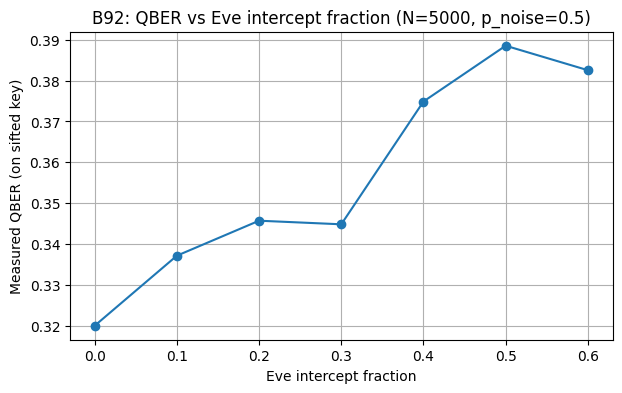

In [ ]:
zero = np.array([[1.0],[0.0]], dtype=complex)
one  = np.array([[0.0],[1.0]], dtype=complex)
plus = (zero + one)/np.sqrt(2)
minus = (zero - one)/np.sqrt(2)

def dens(psi):
    return psi @ psi.conj().T

I2 = np.eye(2, dtype=complex)
P_one = dens(one)
P_minus = dens(minus)

def depolarize(rho, p):
    return (1-p)*rho + p * I2/2

def projective_measure(rho, P0, P1, rng):
    p0 = np.real_if_close(np.trace(P0 @ rho))
    p1 = np.real_if_close(np.trace(P1 @ rho))
    probs = np.array([max(0, float(p0)), max(0, float(p1))])
    s = probs.sum()
    if s <= 0:
        return 0, rho
    probs = probs / s
    outcome = rng.choice([0,1], p=probs)
    P = P0 if outcome == 0 else P1
    post = (P @ rho @ P)
    if probs[outcome] > 0:
        post = post / probs[outcome]
    return int(outcome), post

def pure_state_from_density(rho):
    # find eigenvector with eigenvalue ~1
    vals, vecs = np.linalg.eigh(rho)
    idx = np.argmax(vals)
    v = vecs[:, idx]
    # ensure column vector
    return v.reshape((2,1))

def simulate_b92_with_eve(N=20000, p_noise=0.0, eve_frac=0.0, eve_strategy='random_basis', seed=None):
    rng = np.random.RandomState(seed)
    alice_bits = rng.randint(0,2,size=N)
    bob_bases = rng.randint(0,2,size=N)  # 0 -> Z-check, 1 -> X-check
    intercepted_flags = rng.rand(N) < eve_frac

    sifted_alice = []
    sifted_bob = []
    conclusive = inconclusive = 0
    error_count = 0

    eve_guesses = []
    eve_known_flags = []

    for i in range(N):
        a = int(alice_bits[i])
        psi = zero if a == 0 else plus
        rho = dens(psi)

        if not intercepted_flags[i] and p_noise > 0.0:
            rho = depolarize(rho, p_noise)

        eve_guess = None
        if intercepted_flags[i]:
            if eve_strategy == 'random_basis':
                eve_basis = rng.randint(0,2)  # 0->Z, 1->X
            elif eve_strategy == 'always_z':
                eve_basis = 0
            elif eve_strategy == 'always_x':
                eve_basis = 1
            else:
                eve_basis = rng.randint(0,2)

            if eve_basis == 0:
                P0 = I2 - P_one  # projector onto |0>
                P1 = P_one       # projector onto |1>
                outcome, post = projective_measure(rho, P0, P1, rng)
                eve_guess = 0 if outcome == 0 else 1
            else:
                P0 = I2 - P_minus  # |+>
                P1 = P_minus       # |->
                outcome, post = projective_measure(rho, P0, P1, rng)
                eve_guess = 1 if outcome == 0 else 0

            if p_noise > 0.0:
                rho_to_bob = depolarize(post, p_noise)
            else:
                rho_to_bob = post
        else:
            rho_to_bob = rho
            eve_guess = None

        b_basis = int(bob_bases[i])
        if b_basis == 0:
            outcome, _ = projective_measure(rho_to_bob, I2 - P_one, P_one, rng)
            if outcome == 1:
                conclusive += 1
                sifted_alice.append(a)
                sifted_bob.append(1)
                eve_known_flags.append(eve_guess is not None)
                eve_guesses.append(eve_guess if eve_guess is not None else -1)
                if a != 1:
                    error_count += 1
            else:
                inconclusive += 1
        else:
            outcome, _ = projective_measure(rho_to_bob, I2 - P_minus, P_minus, rng)
            if outcome == 1:
                conclusive += 1
                sifted_alice.append(a)
                sifted_bob.append(0)
                eve_known_flags.append(eve_guess is not None)
                eve_guesses.append(eve_guess if eve_guess is not None else -1)
                if a != 0:
                    error_count += 1
            else:
                inconclusive += 1

    siftA = np.array(sifted_alice, dtype=int)
    siftB = np.array(sifted_bob, dtype=int)
    qber = float(np.mean(siftA != siftB)) if len(siftA) > 0 else float('nan')

    # Compute Eve's info on sifted bits:
    # Consider only sifted positions where Eve intercepted (eve_known_flags True)
    eve_guesses = np.array(eve_guesses, dtype=int) if len(eve_guesses)>0 else np.array([], dtype=int)
    eve_known_flags = np.array(eve_known_flags, dtype=bool) if len(eve_known_flags)>0 else np.array([], dtype=bool)

    if len(eve_guesses)>0 and eve_known_flags.any():
        known_idx = np.where(eve_known_flags)[0]
        if len(known_idx) > 0:
            actual_bits_for_eve = siftA[known_idx]
            eve_bits = eve_guesses[known_idx]
            eve_correct = np.sum(actual_bits_for_eve == eve_bits)
            eve_total_known = len(known_idx)
            eve_accuracy = eve_correct / eve_total_known
        else:
            eve_total_known = 0
            eve_accuracy = float('nan')
    else:
        eve_total_known = 0
        eve_accuracy = float('nan')

    return {
        'N_total': N,
        'p_noise': p_noise,
        'eve_frac': eve_frac,
        'conclusive': conclusive,
        'inconclusive': inconclusive,
        'sifted_len': len(siftA),
        'qber': qber,
        'errors': error_count,
        'eve_known_on_sifted': eve_total_known,
        'eve_accuracy_on_known': eve_accuracy,
        'sifted_alice': siftA,
        'sifted_bob': siftB
    }

N = 5000
p_noise = 0.5
eve_fracs = np.linspace(0.0, 0.6, 7)
seed = 12345

qbers = []
siftlens = []
eve_accs = []
eve_knowns = []

for f in eve_fracs:
    stats = simulate_b92_with_eve(N=N, p_noise=p_noise, eve_frac=f, eve_strategy='random_basis', seed=seed)
    print(f"eve_frac={f:.2f}  | sifted={stats['sifted_len']:4d}  | QBER={stats['qber']:.4f}  | Eve_known={stats['eve_known_on_sifted']:4d}  | Eve_acc={stats['eve_accuracy_on_known']}")
    qbers.append(stats['qber'])
    siftlens.append(stats['sifted_len'])
    eve_accs.append(stats['eve_accuracy_on_known'] if not np.isnan(stats['eve_accuracy_on_known']) else 0.0)
    eve_knowns.append(stats['eve_known_on_sifted'])

plt.figure(figsize=(7,4))
plt.plot(eve_fracs, qbers, marker='o')
plt.xlabel('Eve intercept fraction')
plt.ylabel('Measured QBER (on sifted key)')
plt.title(f'B92: QBER vs Eve intercept fraction (N={N}, p_noise={p_noise})')
plt.grid(True)
plt.show()
